In [266]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
%matplotlib inline

In [267]:
df = pd.read_csv("train.csv")
df = df.loc[:, ~df.columns.duplicated()]

c:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


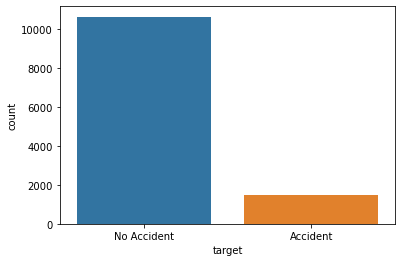

In [268]:
g = sns.countplot(df['target'])
g.set_xticklabels(['No Accident', 'Accident'])

plt.show()

In [269]:
df = df.drop(['ID'], axis = 1)


In [270]:
for col in ['Policy Start Date', 'Policy End Date', 'First Transaction Date']:
    df[col] = df[col].map(lambda x: x.split('-')[0])

In [271]:
#df["Gender"].isin(["Male", "Female", np.nan]).sum()  # 1135 Values


In [272]:
gender = df.Gender[df['Gender'].isin(['Male', 'Female'])].value_counts().to_dict()  
gender = dict(map(lambda g: (g, gender[g] / sum(gender.values())), gender.keys()))

def homogenize_gender(g):
    if g not in ["Male", "Female"]:
        g = random.choices(list(gender.keys()), list(gender.values()))[0]
    return g

df.Gender = df.Gender.map(lambda g: homogenize_gender(g))

from sklearn.preprocessing import LabelEncoder

gender_LE = LabelEncoder()
df.Gender = gender_LE.fit_transform(df.Gender)

In [273]:
age_dict = {-76: 76, -2: 20, 140: 40, 320: 32, -6099: 60, 5939: 39, -22: 22, 144: 44, -27: 27, 133: 33, -51: 51, 128: 28, -26: 26, -5939: 39, 120: 20}

df.replace({"Age": age_dict}, inplace = True)
# for the remaining outliers of age, try median/mean imputer or with probability distribution


In [274]:
#df["Car_Category"][df.Car_Category == "Saloon"]
#Cars = {category: df["Car_Category"][df.Car_Category == "Saloon"] for category in df.Car_Category if df["Car_Category"][df.Car_Category == category].count}
#df.Car_Category.fillna("Saloon")
category_LE = LabelEncoder()
df.Car_Category = category_LE.fit_transform(df.Car_Category)

In [275]:
colours = {colour: sum(df.Subject_Car_Colour == colour) for colour in df.Subject_Car_Colour.value_counts().to_dict() if sum(df.Subject_Car_Colour == colour) > 10}
colours = dict(map(lambda colour: (colour, colours[colour] / sum(colours.values())), colours.keys()))
print(colours)
def impute_colour(col):
    if col not in colours.keys():
        col = random.choices(list(colours.keys()), list(colours.values()))[0]
    return col


impute_colour("Yellow")
df.Subject_Car_Colour = df.Subject_Car_Colour.map(lambda colour: colours[impute_colour(colour)] * 100)   # percentage of presence of the colour in the dataset
#sum(df["Subject_Car_Colour"] == "Black")
#df.Subject_Car_Colour.value_counts()

{'Black': 0.3732380385149891, 'Silver': 0.10998610283899146, 'Grey': 0.10204486797697042, 'As Attached': 0.098868374032162, 'Blue': 0.07166964462973993, 'White': 0.05816954536430415, 'Red': 0.04983124875918205, 'Green': 0.04625769307127258, 'Gold': 0.034345840778241016, 'Ash': 0.026404605916219973, 'Wine': 0.017669247567996822, 'Brown': 0.011514790549930515}


In [276]:
#df.Subject_Car_Make.
cars = {car: sum(df.Subject_Car_Make == car) for car in df.Subject_Car_Make.value_counts().to_dict() if sum(df.Subject_Car_Make == car) > 60}
cars = dict(map(lambda car: (car, cars[car] / sum(cars.values())), cars.keys()))

def impute_car(car):
    if car not in cars.keys():
        car = random.choices(list(cars.keys()), list(cars.values()))[0]
    return car

df.Subject_Car_Make = df.Subject_Car_Make.map(lambda car: cars[impute_car(car)] * 100)   # percentage of presence of the car in the dataset

In [277]:
LGAs = {LGA: sum(df.LGA_Name == LGA) for LGA in df.LGA_Name.value_counts().to_dict() if sum(df.LGA_Name == LGA) > 60}
LGAs = dict(map(lambda LGA: (LGA, LGAs[LGA] / sum(LGAs.values())), LGAs.keys()))
print(LGAs)
def impute_LGA(LGA):
    if LGA not in LGAs.keys():
        LGA = random.choices(list(LGAs.keys()), list(LGAs.values()))[0]
    return LGA

df.LGA_Name = df.LGA_Name.map(lambda LGA: LGAs[impute_LGA(LGA)] * 100)

{'Victoria Island': 0.31036324786324787, 'Ikeja': 0.10710470085470085, 'Surulere': 0.07692307692307693, 'Abuja Municipal': 0.06196581196581197, 'Lagos Mainland': 0.05929487179487179, 'Lagos Island': 0.059027777777777776, 'Eti-Osa': 0.05795940170940171, 'Lekki': 0.055288461538461536, 'Lagos': 0.04487179487179487, 'Ibeju/Lekki': 0.032852564102564104, 'Oshodi-Isolo': 0.02377136752136752, 'Obia/Akpor': 0.022702991452991452, 'Kosofe': 0.0202991452991453, 'Alimosho': 0.017361111111111112, 'Abuja': 0.017094017094017096, 'Benin': 0.01655982905982906, 'Apapa': 0.01655982905982906}


In [278]:
df = df.drop(["State"], axis = 1)  # deal with them later

In [279]:
#product_encoder = {prod_name: sum(df.ProductName == prod_name) for prod_name in df.ProductName.value_counts().to_dict()}
product_encoder = {'Car Vintage': 10, 'Motor Cycle': 20, 'Muuve': 30, 'CarFlex': 40, 'CVTP': 50, 'Car Plus': 60,  'Customized Motor': 70, 'CarSafe': 80, 'Car Classic': 90}
df.replace({"ProductName": product_encoder}, inplace = True)


In [280]:
from sklearn.model_selection import train_test_split, StratifiedKFold

X = df[[col for col in df.columns if col != "target"]]
y = df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2020)

In [281]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report

f1_accuracy_list = []
RF = RandomForestClassifier(n_estimators = 200, random_state = 2020)

SKF1 = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 2020)

for train_index, test_index in SKF1.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    RF.fit(X_train, y_train)
    y_pred = RF.predict(X_test)
    f1_accuracy_list.append(f1_score(y_test, y_pred))

In [282]:
print('List of possible accuracy:', list(map(lambda x: 100 * x, f1_accuracy_list)))
print('\nMaximum Accuracy That can be obtained from this model is:', max(f1_accuracy_list)*100, '%')
print('\nMinimum Accuracy:', min(f1_accuracy_list)*100, '%')
print('\nOverall Accuracy:', statistics.mean(f1_accuracy_list)*100, '%')

List of possible accuracy: [18.912529550827426, 19.607843137254903, 23.27790973871734, 18.95734597156398, 20.361990950226247]

Maximum Accuracy That can be obtained from this model is: 23.27790973871734 %

Minimum Accuracy: 18.912529550827426 %

Overall Accuracy: 20.22352386971798 %


In [283]:
import lightgbm as lgb

LGBM = lgb.LGBMClassifier(learning_rate = 0.9, max_depth = 5, random_state = 2020)
f1_accuracy_list2 = []
SKF2 = StratifiedKFold(n_splits = 5, random_state= 2020, shuffle = True)

for train_i, test_i in SKF2.split(X, y):
    X_train, X_test = X.iloc[train_i], X.iloc[test_i]
    y_train, y_test = y[train_i], y[test_i]
    RF.fit(X_train, y_train)
    y_pred = RF.predict(X_test)
    f1_accuracy_list2.append(f1_score(y_test, y_pred))

In [ ]:
k = 5; seed = 2020
def lgb_f1_score(y_hat, data):
    y_true = data.get_label()
    y_hat = np.round(y_hat)
    return 'f1', f1_score(y_true, y_hat), True

def lgb_train(X, y, X_test, params, verbose = True, verbose_eval = 0, esr = 50, l = [3, 5, 8]):
    pred_test = 0; oofs = []; dict = {} 
    imp_df_Total = pd.DataFrame(columns = ['feature', 'importance_gain', 'importance_seed'])
    params['seed'] = seed
    ######



params = {'ojective': 'binary', 'verbose': -1, 'metric': f1_score, 'seed': 2020}
kf = StratifiedKFold(n_splits = k, ranom_state = seed, shuffle = True); i = 0
for i, (train_i, valid_i) in enumerate(kf.split(X, y)):
    x_train, y_train = X.iloc[train_i], y.iloc[train_i]
    x_valid, y_valid = X.iloc[valid_i], y.iloc[valid_i]
    trn_data = lgb.Dataset(x_train, label = y_train, categorical_feature = cat)
    val_data = lgb.Dataset(x_valid, y_valid, categorical_feature = cat)
    evals_results = {}
    clf = lgb.train(params, trn_data, 10000, valid_sets = [val_data],
    valid_names = ['val'], feval = lgb_f1_score, evals_result = evals_result, verbose_eval = verbose_eval, early_stopping_round = esr)
    oof[valid_i] = clf.predict(x.iloc[valid_i])
    score = f1_score(y_valid, np.where(oof[valid_i] < 0.5, 0, 1))
    pred_test += clf.predict(X_test) / k
    importance_df = pd.DataFrame()
    importance_df["feature"] = 




In [284]:
print('List of possible accuracy:', list(map(lambda x: 100 * x, f1_accuracy_list2)))
print('\nMaximum Accuracy That can be obtained from this model is:', max(f1_accuracy_list2)*100, '%')
print('\nMinimum Accuracy:', min(f1_accuracy_list2)*100, '%')
print('\nOverall Accuracy:', statistics.mean(f1_accuracy_list2)*100, '%')

List of possible accuracy: [18.912529550827426, 19.607843137254903, 23.27790973871734, 18.95734597156398, 20.361990950226247]

Maximum Accuracy That can be obtained from this model is: 23.27790973871734 %

Minimum Accuracy: 18.912529550827426 %

Overall Accuracy: 20.22352386971798 %


In [243]:
#from skopt import BayesSearchCV